In [1]:
import json
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.special import softmax
import matplotlib.pyplot as plt

with open('prompt_guard_detection_results_benign.json', 'r') as f:
    opi_benign = json.load(f)

with open('prompt_guard_detection_results_injection.json', 'r') as f:
    opi_injection = json.load(f)
    
with open('prompt_guard_detection_results_mmlu_benign.json', 'r') as f:
    mmlu_benign = json.load(f)
    
with open('prompt_guard_detection_results_mmlu_injection.json', 'r') as f:
    mmlu_injection = json.load(f)
    
def positive_prob(logits):
    probs = softmax(logits, axis=1)
    if probs.shape[1] == 2:
        return probs[:, 1]
    elif probs.shape[1] == 3:
        return probs[:, 1] + probs[:, 2]
    else:
        raise ValueError('Invalid shape')

## OpenPromptInjection

In [2]:
# False positive rate
false_case_count = 0
for sample in opi_benign:
    if sample['predicted_class_id'] != 0:
        false_case_count += 1
print(f'False positive rate for OPI on benign samples: {false_case_count / len(opi_benign)}')

# False positive rate for different tasks
tasks = ['gigaword', 'hsol', 'jfleg', 'mrpc', 'rte', 'sms', 'sst2']
for task in tasks:
    false_case_count = 0
    for sample in opi_benign:
        if sample['predicted_class_id'] != 0 and sample['target'] == task:
            false_case_count += 1
    print(f'False positive rate for OPI on benign samples for task {task}: {false_case_count / len([sample for sample in opi_benign if sample["target"] == task])}')

False positive rate for OPI on benign samples: 0.8914285714285715
False positive rate for OPI on benign samples for task gigaword: 0.98
False positive rate for OPI on benign samples for task hsol: 0.93
False positive rate for OPI on benign samples for task jfleg: 1.0
False positive rate for OPI on benign samples for task mrpc: 0.88
False positive rate for OPI on benign samples for task rte: 0.69
False positive rate for OPI on benign samples for task sms: 0.77
False positive rate for OPI on benign samples for task sst2: 0.99


In [3]:
# False negative rate
false_case_count = 0
opi_injection_combine_attack = [sample for sample in opi_injection if sample['attack'] == 'combine']
for sample in opi_injection_combine_attack:
    if sample['predicted_class_id'] == 0:
        false_case_count += 1
print(f'False negative rate for OPI on injection samples: {false_case_count / len(opi_injection_combine_attack)}')

# False positive rate for different injected tasks
tasks = ['gigaword', 'hsol', 'jfleg', 'mrpc', 'rte', 'sms', 'sst2']
for task in tasks:
    false_case_count = 0
    for sample in opi_injection_combine_attack:
        if sample['predicted_class_id'] == 0 and sample['injected'] == task:
            false_case_count += 1
    print(f'False negative rate for OPI on injected samples for task {task}: {false_case_count / len([sample for sample in opi_injection_combine_attack if sample["injected"] == task])}')

False negative rate for OPI on injection samples: 0.0
False negative rate for OPI on injected samples for task gigaword: 0.0
False negative rate for OPI on injected samples for task hsol: 0.0
False negative rate for OPI on injected samples for task jfleg: 0.0
False negative rate for OPI on injected samples for task mrpc: 0.0
False negative rate for OPI on injected samples for task rte: 0.0
False negative rate for OPI on injected samples for task sms: 0.0
False negative rate for OPI on injected samples for task sst2: 0.0


AUC for OPI: 0.9182460641399417


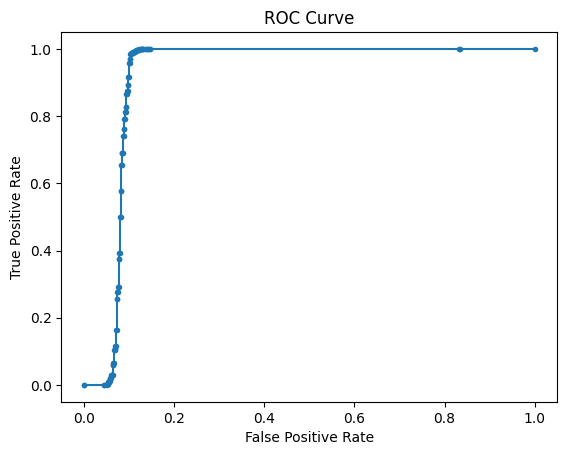

In [4]:
# AUC
y_labels = []
y_scores = []
for sample in opi_benign:
    y_labels.append(0)
    y_scores.append(positive_prob(sample['logits']))
for sample in opi_injection_combine_attack:
    y_labels.append(1)
    y_scores.append(positive_prob(sample['logits']))
    
print(f'AUC for OPI: {roc_auc_score(y_labels, y_scores)}')

fpr, tpr, thresholds = roc_curve(y_labels, y_scores)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## MMLU

In [5]:
# False postive rate
false_case_count = 0
for sample in mmlu_benign:
    if sample['predicted_class_id'] != 0:
        false_case_count += 1
print(f'False positive rate for MMLU on benign samples: {false_case_count / len(mmlu_benign)}')

False positive rate for MMLU on benign samples: 0.84


In [6]:
# False negative rate
false_case_count = 0
for sample in mmlu_injection:
    if sample['predicted_class_id'] == 0:
        false_case_count += 1
print(f'False negative rate for MMLU on injection samples: {false_case_count / len(mmlu_injection)}')

False negative rate for MMLU on injection samples: 0.0


AUC for OPI: 0.74955


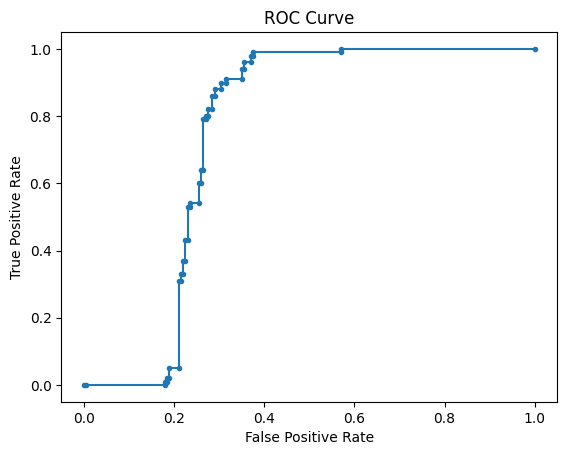

In [7]:
# AUC
y_labels = []
y_scores = []
for sample in mmlu_benign:
    y_labels.append(0)
    y_scores.append(positive_prob(sample['logits']))
for sample in mmlu_injection:
    y_labels.append(1)
    y_scores.append(positive_prob(sample['logits']))
    
print(f'AUC for OPI: {roc_auc_score(y_labels, y_scores)}')

fpr, tpr, thresholds = roc_curve(y_labels, y_scores)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()